In [1]:
import numpy as np
import scipy.stats, scipy.special
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
n_samples = 5000
n = 100
#n_samples = 5
#n = 20
a = 4
b = 1
alpha = 0.05
cuttoff = np.infty
delta = 0.01

In [3]:
#taus
taus = np.zeros(n_samples)

#samples
samples = np.zeros((n_samples, n))

taus = scipy.stats.gamma.rvs(a, scale=b, size=n_samples)

#prevent taus close to zero

for i, tau in enumerate(taus):
    while tau <= delta:
        tau = scipy.stats.gamma.rvs(a, scale=b)

for i in range(n_samples):
    samples[i] = scipy.stats.expon.rvs(loc=0, scale=taus[i], size=n)

In [4]:
print(taus)

[4.7024139  3.4082319  3.23632471 ... 6.96272633 3.25185784 7.87355154]


In [5]:
print(samples)

[[ 2.60577411  6.62343517  4.36878001 ...  6.08969352  1.7755031
   8.30206574]
 [ 3.15217616  1.67978003  2.77987888 ...  8.5003302   3.88171809
   5.67853366]
 [ 0.37340394  0.93419204  7.27982978 ...  3.10498705  2.47186561
   0.79692944]
 ...
 [ 7.69673936  0.42604436  6.267662   ...  1.33227311  3.4310691
   0.06216994]
 [ 1.31282051  2.36585406  5.93532819 ...  0.08855113  3.05715017
   1.52014179]
 [14.5053043  18.95174527  0.18658035 ... 10.53412395 12.74827844
  11.530773  ]]


In [6]:
def prior(tau):
    return scipy.stats.gamma.pdf(tau, a, b)
def lhood(x_list, tau):
    lhood = 1.
    #for x in x_list:
        #lhood *= scipy.stats.expon.pdf(x, tau)
    #print(x_list)
    lhood = scipy.stats.expon.pdf(x_list.sum(), 1./tau)
    #lhood = np.exp(-1. * x_list.sum() / tau)
    return lhood

Text(0.5, 1.0, 'Example of prior for first distribution')

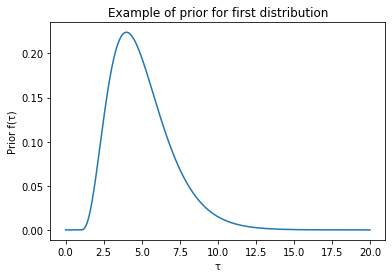

In [7]:
tau_vals = [x for x in np.arange(0.01, 20, 0.01)]
lhood_vals = [lhood(tau, taus[0]) for tau in tau_vals]
prior_vals = [prior(tau) for tau in tau_vals]

plt.plot(tau_vals, prior_vals)
plt.xlabel("τ")
plt.ylabel("Prior f(τ)")
plt.title("Example of prior for first distribution")

In [8]:
#All posteriors saved in a list as lambda functions
post_list = [None]*n_samples
#All bayesian estimators
post_mean = np.ones(n_samples)
#All confidence intervals
post_ci = np.ones(shape=(n_samples,2))
delta_tau = 0.1
conf = 0.05
#How often the sampled tau is inside the confidence interval
tau_interval_count = 0

for i, sample in enumerate(samples):
    print(i)
    print(taus[i])
    #raw unnormalized posterior
    #post_raw = lambda tau: prior(tau)*lhood(samples[i],tau)
    post_raw = lambda tau: tau**(a-1-n) * np.exp(-sum(sample)/(tau) - tau)
    
    #calculate norm and normalize posterior
    #post_norm = scipy.integrate.quad( post_raw, 0, cuttoff)[0]
    #post_final = lambda tau: prior(tau)*lhood(samples[i],tau)/post_norm
    
    #integrate analytically
    #expression obtained from Mathematica
    sample_sum = sum(sample)
    post_norm = 2.*(sample_sum**((a-n)/2.))*scipy.special.kn(n-a, 2.*np.sqrt(sample_sum))
    
    post_final = lambda tau: tau**(a-1-n) * np.exp(-sum(sample)/(tau) - tau) / post_norm
    
    #append posterior distribution to list for saving
    post_list[i] = lambda tau: tau**(a-1-n) * np.exp(-sum(sample)/(tau) - tau) / post_norm
    
    #determine bayesian estimator via integral
    #post_mean_func = lambda tau: tau**(a-n) * np.exp(-sum(sample)/(tau) - tau) / post_norm
    #post_mean[i] = scipy.integrate.quad(post_mean_func, 0, cuttoff)[0]
    
    #integrate analytically
    #expression obtained from Mathematica
    post_mean[i] = 2.*(sample_sum**((a+1-n)/2.))*scipy.special.kn(n-(a+1), 2.*np.sqrt(sample_sum)) / post_norm
    
    """
    Is the 95% interval always symmetric?
    Could it be that the largest symmetric interval has lower confidence, due to cuttoff at τ=0 ?
    In this case, take the largest symmetric interval [0,2*E(τ)]
    """
    """
    ERROR: Numerical reult out of range. Not able to continue computation
    """
    
    tau_min = delta_tau
    tau_max = cuttoff
    
    tau_low = tau_min
    tau_high = post_mean[i]
    
    low_less_conf = True
    high_greater_conf = True
    
    #determine symmetric confidence interval
    
    while low_less_conf:
        tau_low = tau_low + delta_tau
        area = scipy.integrate.quad(post_final, tau_min, tau_low)[0]
        if (area >= 0.5*conf):
            low_less_conf = False
            g_1 = tau_low
    
    while high_greater_conf:
        tau_high = tau_high + delta_tau
        area = scipy.integrate.quad(post_final, tau_high, tau_max)[0]
        if (area <= (0.5*conf)):
            high_greater_conf = False
            g_2 = tau_high
        
    """
    
    less_conf = True
    tau_low = 0
    tau_high = post_mean[i] + post_mean[i]
    
    if scipy.integrate.quad(post_final, tau_low, tau_high)[0] <= conf:
        print("Initial is the best symmetric CI:")
        g_1 = tau_low
        g_2 = tau_high
        less_conf = False
    
    while less_conf:
        area = scipy.integrate.quad(post_final, tau_low, tau_high)[0]
        if area <= conf:
            less_conf = False
            g_1 = tau_low
            g_2 = tau_high
        else:
            tau_low += delta_tau
            tau_high -= delta_tau
    """
    #boundary of confdence interval
    print("{}, {}".format(tau_low, tau_high))
    post_ci[i,0] = g_1
    post_ci[i,1] = g_2
    
    #check if sampled tau is inside interval and count
    if taus[i] >= g_1 and taus[i] <= g_2:
        tau_interval_count += 1
    
    
    
    

0
4.702413898135869
3.900000000000002, 5.706361357206901
1
3.4082319010143296
3.0000000000000013, 4.397897312750587
2
3.2363247099682337
2.9000000000000012, 4.2730241286110155
3
3.236353637079017
2.400000000000001, 3.5771828436634765
4
7.598110116324021
7.39999999999999, 10.633729881201893
5
5.341253263864357
4.699999999999999, 6.86050683337599
6
2.8391589819494323
2.700000000000001, 3.90679651313692
7
4.806803038773909
3.800000000000002, 5.50556621412135
8
4.149778384854999
3.600000000000002, 5.325969090830627
9
1.0877598257923666
0.9999999999999999, 1.4440985625254972
10
2.0490889260696514
1.9000000000000006, 2.8017993105550163
11
4.3019218515955755
3.5000000000000018, 5.05773347331836
12
7.250108701967633
5.4999999999999964, 7.989784332128795
13
3.251107006530999
2.500000000000001, 3.669579113236558
14
2.7199168719511073
2.2000000000000006, 3.168310824008374
15
3.8831949261658
3.600000000000002, 5.30701737046968
16
2.632595531470723
2.700000000000001, 3.9549439881767072
17
3.1359973

2.2000000000000006, 3.176750937438119
150
1.7434278087217783
1.7000000000000004, 2.475080160172188
151
5.720018594137302
4.799999999999999, 7.092698772856782
152
9.416324292258714
7.799999999999988, 11.259444310532793
153
6.020302902608445
4.699999999999999, 6.826764231546067
154
6.666969470832439
5.399999999999997, 7.867203341584025
155
2.471660077135713
1.8000000000000005, 2.6373301746112503
156
4.583865637116419
3.700000000000002, 5.418128401132201
157
5.358987888045645
5.299999999999997, 7.781775633179184
158
0.3034148103775616
0.30000000000000004, 0.4081780613785102
159
2.034111818471844
1.9000000000000006, 2.6929394419077046
160
7.764889329903997
5.999999999999995, 8.714755943325613
161
1.553345863446066
1.3, 1.8843665667788214
162
7.1768259270495065
5.099999999999998, 7.458014145470412
163
1.547175004534346
1.0999999999999999, 1.5525561223022675
164
2.0900517292976484
1.9000000000000006, 2.7809181091321014
165
4.6246159405174305
3.600000000000002, 5.355914155552434
166
3.8019581

3.700000000000002, 5.394038173033666
291
2.2523453755955445
1.9000000000000006, 2.708655881082459
292
2.0175333235682347
1.4000000000000001, 2.0649500223726593
293
3.3141387401329037
3.0000000000000013, 4.370143416027111
294
5.741463391615665
3.900000000000002, 5.64593127689732
295
1.5876991395898854
1.5000000000000002, 2.1541325322998697
296
4.853766545804799
5.099999999999998, 7.441611758077421
297
2.556565362962311
2.0000000000000004, 2.9551302674503668
298
2.810753870828611
2.500000000000001, 3.7086375759542514
299
3.760365502837291
3.800000000000002, 5.536510260230934
300
2.294580192924021
1.9000000000000006, 2.7340612761598826
301
3.227884165468723
2.400000000000001, 3.5986243683802703
302
2.1889130438718927
1.8000000000000005, 2.620704641441019
303
2.6694108665013094
2.1000000000000005, 3.058664344149501
304
5.311673166452661
4.799999999999999, 6.895919697148564
305
3.8601814765289233
3.1000000000000014, 4.47114368404643
306
5.3018629194013345
4.300000000000001, 6.24266553487897

2.3000000000000007, 3.326879014517808
432
1.5788453579655441
1.5000000000000002, 2.105994711555435
433
2.0974790318840983
1.6000000000000003, 2.2401793021913816
434
6.0769153071662965
4.899999999999999, 7.135985796161734
435
4.694741480411855
4.200000000000001, 6.093006651242811
436
4.032111169066071
3.600000000000002, 5.291026597683321
437
2.671167779068664
2.500000000000001, 3.6455877130365026
438
3.905294936737295
3.2000000000000015, 4.7419607080466735
439
6.33699491007543
5.4999999999999964, 7.952241818912776
440
2.4782803354265908
2.3000000000000007, 3.2829224687548617
441
3.600076044497788
3.0000000000000013, 4.348476126674473
442
8.21013798991057
6.499999999999993, 9.360589119994623
443
5.195736528930233
4.100000000000001, 5.984295814085021
444
2.6916392373927325
1.7000000000000004, 2.5694911914362177
445
4.990874857619183
4.5, 6.639796440020986
446
1.4069003311579285
1.4000000000000001, 2.0205007943773867
447
3.5259763032779055
3.3000000000000016, 4.892485600128654
448
4.988199

1.9000000000000006, 2.7340803960852673
575
3.154310090814006
2.700000000000001, 3.9107043360949985
576
2.6780863807577373
2.1000000000000005, 3.124984435054606
577
4.875993808841895
4.4, 6.327297177002315
578
7.051961272894019
5.799999999999995, 8.437008008009782
579
5.737477930956434
5.399999999999997, 7.890470168493144
580
3.782039493345063
3.2000000000000015, 4.698154024764183
581
2.56214907364768
2.3000000000000007, 3.3328911851361815
582
5.66183038276616
5.099999999999998, 7.390152040420817
583
5.022365630268452
4.100000000000001, 6.012757079911556
584
6.812016229886218
6.399999999999993, 9.20517453495126
585
4.05820553484574
3.4000000000000017, 4.939028041473334
586
8.096494201754792
6.5999999999999925, 9.435334695009816
587
4.058843127772611
3.2000000000000015, 4.674650404164344
588
2.5553980023635323
1.9000000000000006, 2.7489566002006214
589
2.8159528993463274
2.3000000000000007, 3.357230007817575
590
4.761703754436451
3.800000000000002, 5.520458507779429
591
2.674173156092491

3.4000000000000017, 4.945180394942089
719
3.814140009786444
2.800000000000001, 4.175147366224229
720
4.00062294330587
3.600000000000002, 5.346145547007735
721
1.5711562966607466
1.3, 1.8727699918390308
722
2.4308721735315975
2.2000000000000006, 3.160554082032913
723
6.579444049590171
5.799999999999995, 8.39157660577827
724
1.9475545066262034
1.9000000000000006, 2.7018426273222715
725
3.0935493530557885
2.800000000000001, 4.082281133748691
726
6.514636561243373
4.899999999999999, 7.192273217329757
727
3.9447835084096172
3.4000000000000017, 5.006853151150054
728
4.046844020007389
3.5000000000000018, 5.108905678142329
729
3.106033394688921
2.700000000000001, 3.97122323946769
730
5.196598375906719
4.200000000000001, 6.138337430882813
731
5.820642024526599
5.399999999999997, 7.806051796704905
732
2.358146072144285
1.9000000000000006, 2.797995942746607
733
1.6626454075173527
1.5000000000000002, 2.2238094202198355
734
1.1547375573304912
1.0999999999999999, 1.5335308864835593
735
4.72794993037

5.399999999999997, 7.822922367516005
860
1.8861995983615953
1.8000000000000005, 2.650825339661536
861
3.3081978827129372
2.700000000000001, 3.8875765598078766
862
3.5106129731131177
2.700000000000001, 3.8920755522748705
863
3.438443851162572
2.500000000000001, 3.7333276616666393
864
2.0343714497070664
1.6000000000000003, 2.379964199229722
865
8.486150653574803
7.599999999999989, 10.996820759035916
866
3.2498562787653653
2.500000000000001, 3.6772169986603207
867
2.119239056360392
1.9000000000000006, 2.7532958386199198
868
8.588727092497043
5.4999999999999964, 7.9623579595755425
869
7.486709151814672
5.699999999999996, 8.16769580137522
870
3.9431136906675177
3.2000000000000015, 4.744090486014374
871
1.2158501277177383
0.9999999999999999, 1.512992712748141
872
2.8447136162470366
2.400000000000001, 3.530793883091318
873
1.3822949622061151
1.2, 1.811345216044892
874
4.740684802059537
3.3000000000000016, 4.869770199145112
875
2.7382884595421704
2.400000000000001, 3.5183664812356983
876
3.614

6.299999999999994, 9.193844084806253
1001
3.8130161349827043
3.0000000000000013, 4.325054107106333
1002
1.3750501177797265
1.3, 1.9578726590016626
1003
9.592602826135002
7.29999999999999, 10.501472971530074
1004
3.3400776740191347
2.600000000000001, 3.7995877257207833
1005
3.750794322720398
3.2000000000000015, 4.731981850011788
1006
7.964374530526543
7.499999999999989, 10.751293798724717
1007
2.4207813336583657
1.8000000000000005, 2.6423352705087053
1008
1.6753476373723335
1.5000000000000002, 2.120889258873339
1009
2.904518611906258
2.400000000000001, 3.600260881685071
1010
2.4941759131499426
2.1000000000000005, 3.147672377033992
1011
1.5792205992788988
1.4000000000000001, 2.075242391049331
1012
3.509822687582362
3.0000000000000013, 4.323600784268549
1013
3.826803049757654
2.500000000000001, 3.697932491312118
1014
1.5239276850421755
1.5000000000000002, 2.145615590886007
1015
3.105874629233939
3.2000000000000015, 4.750814756223584
1016
2.406746078703755
2.1000000000000005, 3.12535247493

7.29999999999999, 10.508964369088739
1141
1.6881048870837019
1.8000000000000005, 2.605024956921556
1142
0.39140302783985714
0.4, 0.5278721296151327
1143
4.0300988229906
3.4000000000000017, 4.949689982345257
1144
4.082964494415937
3.1000000000000014, 4.547277685218696
1145
2.803525323092731
2.600000000000001, 3.752374262948069
1146
4.656551998761688
3.5000000000000018, 5.117408887950437
1147
4.722232994937249
4.100000000000001, 5.956805498621247
1148
4.470584933636364
3.600000000000002, 5.286004858077452
1149
2.7758733923806402
2.800000000000001, 4.110606106102129
1150
2.490782638390461
2.0000000000000004, 3.012080235197983
1151
2.9374617557104434
2.3000000000000007, 3.374455361654621
1152
2.306551338710897
2.0000000000000004, 2.96329911610098
1153
6.259429370673203
4.5, 6.601423054191279
1154
3.0739525281024953
2.600000000000001, 3.8172779571467297
1155
3.9719345445165977
3.2000000000000015, 4.756882224180635
1156
5.484403300831232
4.899999999999999, 7.195412399548358
1157
2.2442658732

3.800000000000002, 5.585135828143128
1281
2.8105883859019585
2.600000000000001, 3.7833967783732834
1282
2.5190107058040314
2.500000000000001, 3.626942648373924
1283
3.7324531336231983
2.600000000000001, 3.7445031217582123
1284
1.9539247602918148
1.5000000000000002, 2.224237625869868
1285
1.9557135603532818
2.0000000000000004, 2.994670936026433
1286
5.127481745640503
4.899999999999999, 7.207673904123199
1287
1.8774785524507984
1.7000000000000004, 2.487473104279694
1288
1.25538059121463
0.9999999999999999, 1.503724198571335
1289
2.5162437996519937
2.1000000000000005, 3.034677346201618
1290
2.84735338154392
2.400000000000001, 3.516527770067602
1291
4.624520759238552
3.4000000000000017, 5.012945953262024
1292
2.6374018268692603
2.2000000000000006, 3.198342355372842
1293
7.1203356187708655
6.399999999999993, 9.234586602359533
1294
3.832476879026511
3.800000000000002, 5.54254154653811
1295
2.3265069071522912
2.3000000000000007, 3.3028496174286786
1296
4.527607295055461
3.2000000000000015, 4.

1.8000000000000005, 2.663315444088035
1418
4.416314600314005
4.000000000000002, 5.73018477691307
1419
3.0984738562288467
3.0000000000000013, 4.355943071418348
1420
4.531346807588296
3.800000000000002, 5.519166176111119
1421
4.955775572202016
4.000000000000002, 5.744365025386101
1422
4.650433883806819
3.900000000000002, 5.609307972621222
1423
2.1634655913303886
1.8000000000000005, 2.617681376850952
1424
2.924128860042766
2.800000000000001, 4.166360955264024
1425
3.1301415113201436
2.9000000000000012, 4.2462912035326195
1426
5.870591882476369
3.600000000000002, 5.297438358406335
1427
5.721544792852845
4.899999999999999, 7.1765288122769455
1428
2.468848795433423
2.0000000000000004, 2.9726527714992153
1429
1.7462044742570715
1.7000000000000004, 2.5548625270062244
1430
10.552871738875908
8.099999999999987, 11.728310101129775
1431
4.559776146566024
4.200000000000001, 6.1040972613380085
1432
1.6107707352237692
1.5000000000000002, 2.1349615884794098
1433
2.6880456364206804
2.400000000000001, 3

3.0000000000000013, 4.35760933548891
1561
3.223402183721128
2.600000000000001, 3.8251145124907007
1562
3.5496642763229165
2.9000000000000012, 4.218829764871774
1563
4.663480276904409
3.800000000000002, 5.538460574352385
1564
1.8115854573513706
1.6000000000000003, 2.3832413105602686
1565
2.0113700790040854
1.6000000000000003, 2.4482322018541796
1566
2.3810376588688316
2.3000000000000007, 3.376403729632134
1567
1.7026503987875607
1.4000000000000001, 2.0923307314465074
1568
4.928156259868834
4.300000000000001, 6.216656971452585
1569
2.699506189388336
2.1000000000000005, 3.1146643794070394
1570
3.606794111499229
2.600000000000001, 3.827387934886587
1571
2.2701806091843664
1.8000000000000005, 2.633554827409366
1572
3.0202398029385376
2.800000000000001, 4.138953077103469
1573
4.2739932382413475
3.0000000000000013, 4.412966064159261
1574
4.37809726998966
3.800000000000002, 5.5302853873042075
1575
2.060512178547191
1.6000000000000003, 2.2413774666280353
1576
3.5144852093340857
3.20000000000000

4.4, 6.328327600884514
1701
0.6678022193775718
0.6, 0.9004559785488458
1702
2.545130662794729
2.1000000000000005, 3.1269071105867368
1703
3.7807765340716526
3.5000000000000018, 5.053178344306945
1704
4.590653411491024
3.700000000000002, 5.4084139165532665
1705
2.1148664116907927
1.7000000000000004, 2.568320927418611
1706
3.285095000185418
2.700000000000001, 3.948092602997201
1707
2.65431498968537
2.400000000000001, 3.5453379291227907
1708
4.112984082108501
3.600000000000002, 5.266102776963458
1709
6.36406064051319
6.799999999999992, 9.816840307354925
1710
3.059741576162519
3.0000000000000013, 4.440059691596812
1711
1.6173569012357494
1.4000000000000001, 2.071699513098262
1712
2.4690530552223686
2.1000000000000005, 3.0971672830785804
1713
8.093159223341315
7.499999999999989, 10.762315161473701
1714
2.2585945898279394
2.0000000000000004, 2.9442650929349106
1715
1.8128438995938378
1.6000000000000003, 2.439820107377078
1716
2.959985313519285
2.3000000000000007, 3.335756925849539
1717
3.490

6.099999999999994, 8.748910176608536
1845
4.352766014299484
3.800000000000002, 5.5162531245432085
1846
7.904602459077263
6.499999999999993, 9.377281412147543
1847
2.1378041235710294
1.7000000000000004, 2.5509894604009493
1848
4.353902636394119
4.000000000000002, 5.745960545816864
1849
2.1479517189443618
1.8000000000000005, 2.583316528328591
1850
6.204316944701462
5.099999999999998, 7.407274084289652
1851
6.09766619361045
5.899999999999995, 8.51103694540614
1852
8.178674784185144
6.699999999999992, 9.759433705851498
1853
3.6660660621399583
3.0000000000000013, 4.430651926766947
1854
9.287252517698855
6.8999999999999915, 9.893921107565971
1855
2.046584685945504
1.9000000000000006, 2.711898531165311
1856
3.564412287302422
3.700000000000002, 5.367426362638673
1857
2.0890054471328208
2.0000000000000004, 2.9875590837320556
1858
4.055198263411853
3.5000000000000018, 5.119340423281077
1859
2.1936618124560763
1.9000000000000006, 2.7904515095729354
1860
6.212629925848591
4.4, 6.350588370766736
18

9.699999999999982, 13.900960628576303
1987
1.1513086406957327
0.9999999999999999, 1.4518999090050089
1988
3.6052006978516404
3.2000000000000015, 4.746160417342517
1989
5.035061384336523
3.600000000000002, 5.344976686632281
1990
3.907428956033236
3.1000000000000014, 4.519092644086425
1991
4.130726557075977
3.3000000000000016, 4.90231775490433
1992
2.4000885536802796
2.2000000000000006, 3.222811892492663
1993
5.825029941099685
4.4, 6.327642839461922
1994
3.766482191597731
3.5000000000000018, 5.075714765272926
1995
4.123035541388478
3.5000000000000018, 5.120439759251955
1996
6.132531529153293
4.000000000000002, 5.939486999654081
1997
3.126020979326991
2.500000000000001, 3.7152724079652755
1998
6.796371695879181
5.099999999999998, 7.364755227163868
1999
1.732744430094566
1.5000000000000002, 2.194002476523369
2000
4.244050212518397
3.3000000000000016, 4.785820602092635
2001
2.3164685522129114
1.7000000000000004, 2.4875168688717557
2002
1.9804890365277061
1.8000000000000005, 2.61062625015552

3.1000000000000014, 4.552010091664491
2128
1.5987116642767145
1.5000000000000002, 2.146235732138847
2129
1.376738378406991
1.2, 1.7827942934380838
2130
2.2090345725619684
2.0000000000000004, 3.011205942253388
2131
4.740717430790652
3.600000000000002, 5.305405694790044
2132
5.06928180062266
4.100000000000001, 6.063020690043337
2133
5.448668898899571
4.799999999999999, 6.916084328128248
2134
2.2589742492707456
2.0000000000000004, 2.9459324103511633
2135
3.856889054902846
3.0000000000000013, 4.343845941484813
2136
2.9813921116379776
2.500000000000001, 3.655720375231083
2137
3.434810086485775
3.0000000000000013, 4.396095909259556
2138
2.9529877330612995
2.400000000000001, 3.577415810561654
2139
4.206877812478341
3.600000000000002, 5.30486720286866
2140
2.527358196472343
2.600000000000001, 3.785009666776674
2141
6.3990916069274615
5.099999999999998, 7.374181037153048
2142
6.4273704919516454
5.4999999999999964, 7.992286848587732
2143
4.666777649557924
4.699999999999999, 6.794598672810451
214

3.0000000000000013, 4.414892098704359
2267
7.239697880381394
4.699999999999999, 6.865999415957944
2268
4.594576656028947
4.5, 6.621066138561882
2269
5.298223058785022
4.300000000000001, 6.2399838067569755
2270
4.227841978428245
3.800000000000002, 5.490413840373327
2271
2.076668744731532
1.5000000000000002, 2.144060839853713
2272
2.583402647824497
2.1000000000000005, 3.125197216177155
2273
1.828353233419484
1.4000000000000001, 2.04924608370361
2274
6.0778377905122305
5.299999999999997, 7.70779828898262
2275
1.4401615008598323
1.5000000000000002, 2.1403744651684895
2276
3.3961357848599234
2.9000000000000012, 4.278366491465706
2277
3.0143763740281115
2.400000000000001, 3.5495052337076793
2278
2.97217719151428
3.0000000000000013, 4.406648517631572
2279
3.1120328396230654
2.3000000000000007, 3.310538816967537
2280
7.911895745456091
6.399999999999993, 9.218996006018612
2281
1.08915702640708
0.8999999999999999, 1.3892683787015414
2282
6.794013530689221
4.999999999999998, 7.243088119292078
228

4.200000000000001, 6.165581689455479
2406
2.587734195511398
1.8000000000000005, 2.6367207537283712
2407
5.254426014205221
4.799999999999999, 6.9824897968576165
2408
3.752264886318726
2.9000000000000012, 4.25018817358416
2409
1.2368230217766991
0.9999999999999999, 1.505969356496326
2410
2.9374187517854358
2.9000000000000012, 4.230655031979605
2411
5.949847943914884
4.699999999999999, 6.81750793935389
2412
3.970526934556083
3.4000000000000017, 4.929663286484839
2413
3.0592360774831717
2.700000000000001, 3.8972447421640006
2414
6.534840464908902
6.199999999999994, 9.045314403288858
2415
1.9672545180408851
2.1000000000000005, 3.0398959399931957
2416
2.640439421250079
2.400000000000001, 3.523198531959976
2417
5.675501527252274
5.399999999999997, 7.832421495433589
2418
5.132246087845125
5.299999999999997, 7.746367847967375
2419
1.8714818053657922
1.7000000000000004, 2.561581588879874
2420
4.649101758068164
3.5000000000000018, 5.058718167086751
2421
2.5642073939081294
2.0000000000000004, 2.95

4.699999999999999, 6.787397198592394
2552
1.7806688490039733
1.6000000000000003, 2.3809752145071794
2553
7.20936742559445
5.4999999999999964, 7.962720329876178
2554
3.6938272350225527
3.2000000000000015, 4.696110031010476
2555
2.6390912758288603
2.2000000000000006, 3.198545154945044
2556
3.123095794622808
2.3000000000000007, 3.326992814057305
2557
2.4107959750436168
2.2000000000000006, 3.2557088113599577
2558
3.2586055680336163
2.9000000000000012, 4.2924287611511245
2559
1.8431677618403506
1.7000000000000004, 2.4778472565338334
2560
2.685523420096295
2.600000000000001, 3.7455562848495156
2561
5.500744639462774
4.899999999999999, 7.17151770813608
2562
4.0825750179798055
3.700000000000002, 5.48425508660029
2563
2.0860715776291308
1.9000000000000006, 2.709703050978088
2564
3.3178587079540973
2.800000000000001, 4.178426698548673
2565
6.458660930653488
5.299999999999997, 7.751738591338811
2566
2.8550406166000113
2.800000000000001, 4.172962654876162
2567
1.963257734568906
1.8000000000000005,

3.2000000000000015, 4.72967499036216
2696
3.5480079651857266
3.1000000000000014, 4.556663749963549
2697
4.148277075772452
4.100000000000001, 5.994689910265699
2698
5.734574751721834
4.100000000000001, 6.0364253624580435
2699
2.0003819864612478
1.8000000000000005, 2.6376465770679625
2700
5.594510808701489
4.300000000000001, 6.2404235409234
2701
1.8318425616255536
1.6000000000000003, 2.3802950656884017
2702
4.911445788707536
3.800000000000002, 5.501443931601574
2703
4.986005385233345
4.000000000000002, 5.919158379791492
2704
2.8407388530421986
2.3000000000000007, 3.3157225077720507
2705
2.3972007119072067
2.1000000000000005, 3.067997577625153
2706
2.3291785275191774
2.1000000000000005, 3.0596641924399477
2707
3.8135297384329014
2.800000000000001, 4.1192329879342005
2708
5.142381796616782
4.6, 6.751709834082928
2709
3.4020634104725533
2.9000000000000012, 4.249968694457898
2710
0.8773500244729392
0.7999999999999999, 1.0952942263970913
2711
2.743388814337394
2.1000000000000005, 3.1321819132

3.1000000000000014, 4.493134554159151
2833
7.686736512089237
5.399999999999997, 7.8838805840640385
2834
1.840794351020687
1.5000000000000002, 2.218181773950153
2835
3.2619115529695524
2.9000000000000012, 4.227723678525465
2836
4.962040882806565
3.700000000000002, 5.422753060647939
2837
1.4219697477983901
1.3, 1.9078070376646257
2838
3.746295704345606
2.700000000000001, 3.9394152758121326
2839
6.032820202977188
5.299999999999997, 7.778267330786836
2840
2.0741886022300817
1.8000000000000005, 2.603186967220374
2841
3.9331494661283215
3.1000000000000014, 4.492235553759669
2842
5.819580722373343
4.899999999999999, 7.134062414310921
2843
10.162434633863146
8.799999999999985, 12.559287725549888
2844
3.8309000282726915
3.4000000000000017, 4.9151387330926335
2845
2.462962327943435
1.9000000000000006, 2.785396846425566
2846
1.168481647682599
0.9999999999999999, 1.4394377325982164
2847
2.4744522676867726
2.2000000000000006, 3.267660378259777
2848
1.5949536640284834
1.6000000000000003, 2.374529329

5.599999999999996, 8.092198757715211
2970
2.5474717951210235
2.400000000000001, 3.508042779820746
2971
3.1904585659831795
3.0000000000000013, 4.365176715346852
2972
1.4686338276091655
1.0999999999999999, 1.5575479649220232
2973
3.260373010556454
3.2000000000000015, 4.7701443951938876
2974
4.111050492329129
3.5000000000000018, 5.062469702116074
2975
1.8173462758604164
1.3, 1.8752065460133232
2976
6.159227405842679
5.1999999999999975, 7.512441175517665
2977
4.084288688502851
3.5000000000000018, 5.074763718539945
2978
2.7619096276385835
2.1000000000000005, 3.1457218234689575
2979
4.099738857449456
3.3000000000000016, 4.797116083748444
2980
4.654824602563232
3.5000000000000018, 5.12452384313126
2981
1.2357207847323413
1.2, 1.8067485017985334
2982
4.179395644091044
3.800000000000002, 5.533237242992464
2983
6.459214101255668
4.799999999999999, 6.908706831432634
2984
2.3785332066577616
2.1000000000000005, 3.0503658203951556
2985
2.793409359582898
2.600000000000001, 3.7962130644767487
2986
3.0

2.9000000000000012, 4.280414902717933
3110
1.5310021968551295
1.2, 1.6645254890224896
3111
3.6110055591747123
2.800000000000001, 4.160942217169571
3112
5.36017433576526
4.4, 6.51574346671127
3113
2.5961135541570965
2.400000000000001, 3.50731127499284
3114
5.291081277975135
5.099999999999998, 7.359984696667219
3115
3.72729959431262
3.2000000000000015, 4.7200478426277686
3116
5.1531470918673925
4.000000000000002, 5.868273729507535
3117
4.214907263649409
3.800000000000002, 5.543266143526304
3118
2.0681398746622053
1.8000000000000005, 2.6552886769827704
3119
3.046506547089367
2.600000000000001, 3.7820201257432897
3120
2.9952307895682466
2.700000000000001, 3.905552187713003
3121
2.530306067512022
2.500000000000001, 3.698568627282297
3122
4.049565201748285
3.3000000000000016, 4.820648899879913
3123
8.641799782551333
8.999999999999984, 12.89046253933646
3124
5.99526331866086
4.999999999999998, 7.321467455223464
3125
6.3874184610664875
4.799999999999999, 7.0880961147244665
3126
2.4477487929466

5.399999999999997, 7.807767939680687
3251
7.178830935479752
5.899999999999995, 8.579568606457075
3252
0.7009537720145552
0.7, 1.012260641315761
3253
5.138960023541286
4.5, 6.611983512837757
3254
1.7563655654167853
1.4000000000000001, 2.068696334147583
3255
3.181864846340704
2.800000000000001, 4.163687673684203
3256
1.9194219490705118
1.7000000000000004, 2.49923080823574
3257
6.469274043356653
4.899999999999999, 7.2165885993542185
3258
2.6383479668821828
2.500000000000001, 3.6483024436701856
3259
1.3041080585267044
1.2, 1.8008762835277692
3260
3.982848445243833
3.4000000000000017, 4.94737709038772
3261
6.942302942696614
5.399999999999997, 7.844374266306522
3262
1.9339329515101809
1.7000000000000004, 2.457457106222311
3263
5.473029166922118
4.699999999999999, 6.8250734319418545
3264
1.095106045506026
1.0999999999999999, 1.524681425483251
3265
7.18623494663856
5.4999999999999964, 7.960044453166161
3266
4.3965377867105015
3.3000000000000016, 4.872925067333455
3267
1.8195468410995674
1.4000

7.499999999999989, 10.908683880769079
3393
2.3798564648936207
2.2000000000000006, 3.1696898672394873
3394
1.6566224708210968
1.4000000000000001, 1.9882083835178082
3395
6.8679129723522
5.599999999999996, 8.135664701277367
3396
7.50335056006705
5.999999999999995, 8.710072089624546
3397
4.314649368241806
4.200000000000001, 6.112469758172493
3398
3.4875404937806618
2.800000000000001, 3.9800735490307377
3399
3.065205065718251
2.3000000000000007, 3.346072545556797
3400
4.196309793206742
3.4000000000000017, 4.904461667358123
3401
3.5899741142904897
2.9000000000000012, 4.240431818988445
3402
3.3638536534998074
3.0000000000000013, 4.416552762574827
3403
2.2386622431064556
1.8000000000000005, 2.6696309097749626
3404
1.8841720289274118
1.4000000000000001, 2.1045521339903885
3405
3.8367296511232007
3.4000000000000017, 4.968327562148265
3406
4.131257748873093
3.3000000000000016, 4.865787470379718
3407
2.4563883408702933
2.0000000000000004, 2.992247714784543
3408
2.652269931693734
2.200000000000000

7.19999999999999, 10.359336704760091
3533
2.7442098474221313
2.600000000000001, 3.7598744222208356
3534
6.571848998747634
5.299999999999997, 7.786613506156108
3535
3.651963058889171
3.3000000000000016, 4.834787627164615
3536
2.8036442026565416
2.3000000000000007, 3.2807817740608445
3537
1.5722326331463434
1.5000000000000002, 2.225900554262229
3538
7.0303159438559195
5.4999999999999964, 7.948779949141757
3539
3.883606344041295
2.9000000000000012, 4.30142329977894
3540
2.881691359484816
2.1000000000000005, 3.1401682443195504
3541
3.141381108019897
2.600000000000001, 3.798983517829994
3542
5.155158950969559
4.300000000000001, 6.294265792673068
3543
2.8791752417476877
2.400000000000001, 3.4985490239883776
3544
2.164127371564908
1.9000000000000006, 2.7462310234576597
3545
3.453289827967597
2.9000000000000012, 4.2345191228248655
3546
3.3984016176605314
2.9000000000000012, 4.298783831467889
3547
3.3595583013401504
3.2000000000000015, 4.733660519156157
3548
2.8996148832614352
1.900000000000000

6.999999999999991, 10.05986233080906
3673
2.838690629550923
2.700000000000001, 3.8602565721388764
3674
3.9791399124436633
3.0000000000000013, 4.392547086417181
3675
6.355581449224659
5.399999999999997, 7.868573165208304
3676
4.1743134464806
3.700000000000002, 5.420601318613398
3677
1.1933887661944191
1.0999999999999999, 1.6250670389469748
3678
3.1425368849916593
3.0000000000000013, 4.439770335244942
3679
4.156179214994562
3.4000000000000017, 4.908701603153945
3680
7.644782474103338
6.8999999999999915, 9.969295642419535
3681
3.868521988833906
3.3000000000000016, 4.811608046364243
3682
2.226530832683393
2.1000000000000005, 3.040267247356366
3683
4.206638929384498
3.3000000000000016, 4.795019642008679
3684
7.262590978644712
5.599999999999996, 8.083135360444933
3685
2.5995227628982627
2.3000000000000007, 3.3028637650996626
3686
2.783301016375895
2.600000000000001, 3.8140061504057465
3687
2.621579045114299
2.700000000000001, 3.921007960061384
3688
1.710281681542393
1.5000000000000002, 2.185

6.699999999999992, 9.706295779752224
3813
8.418665808557193
6.8999999999999915, 9.943848936482434
3814
5.296711474820167
4.200000000000001, 6.140281664130809
3815
2.6374499988399425
2.400000000000001, 3.544954814963581
3816
1.4837720532311989
1.2, 1.6642395495255895
3817
3.6431673104707847
3.4000000000000017, 4.925462995123816
3818
4.580527513772998
3.800000000000002, 5.540050843860464
3819
2.408810167577786
2.0000000000000004, 2.9252076440352126
3820
4.456512908113559
4.300000000000001, 6.3040130439832325
3821
1.8435517507813701
1.8000000000000005, 2.6813912636774377
3822
2.667331586866732
2.1000000000000005, 3.0446435686242332
3823
3.194475199356488
3.0000000000000013, 4.322541936476261
3824
8.543173929826983
6.499999999999993, 9.38290148946971
3825
2.2667667743943256
1.8000000000000005, 2.6708497318294104
3826
4.5690095561708
3.900000000000002, 5.644499648026332
3827
2.0741840333991144
1.8000000000000005, 2.606887120026767
3828
1.9124706347790168
1.6000000000000003, 2.23509320670665

4.6, 6.67489887208277
3951
6.631681259287936
4.899999999999999, 7.158890491305712
3952
4.843972391741992
4.100000000000001, 5.978843875986326
3953
3.3751229201348463
3.3000000000000016, 4.800237247642297
3954
2.3675951073942416
2.1000000000000005, 3.084593333052968
3955
2.5546897530955364
2.3000000000000007, 3.3803275665104597
3956
3.937472823482221
3.0000000000000013, 4.4114914684862185
3957
3.7692088351892847
3.600000000000002, 5.149364724780932
3958
5.585676842790021
4.699999999999999, 6.876025253168644
3959
1.5207845296846272
1.2, 1.8247052485332815
3960
6.4534891900576445
5.599999999999996, 8.056448891651785
3961
11.692203329846981
8.599999999999985, 12.312010622221115
3962
3.5459532150608375
3.2000000000000015, 4.732245803330629
3963
3.2612941925692347
2.700000000000001, 3.9498026459294535
3964
3.428071915270927
2.500000000000001, 3.68389424542854
3965
3.8667508425599686
3.5000000000000018, 5.07008518719296
3966
3.125480483668006
2.9000000000000012, 4.244268601028123
3967
1.06939

2.400000000000001, 3.5406579049518188
4088
7.040355010346382
5.899999999999995, 8.578495776863747
4089
4.149445248306224
3.2000000000000015, 4.7426651747387805
4090
4.2746289543957525
3.1000000000000014, 4.4741221531667685
4091
3.5970663094656112
3.2000000000000015, 4.7602895513812165
4092
1.244170411250652
1.0999999999999999, 1.6073386001330263
4093
2.6341291879316713
2.0000000000000004, 2.9899141611942195
4094
4.513417236074026
3.3000000000000016, 4.866263479620932
4095
2.8686010099231254
2.500000000000001, 3.6187627831451588
4096
2.0424958066268024
1.9000000000000006, 2.8075367969086105
4097
2.1985868996554085
1.7000000000000004, 2.5025364882787784
4098
7.111653448281221
6.099999999999994, 8.832339249941036
4099
2.7855790417160953
2.400000000000001, 3.4997360292786976
4100
6.418952631503038
5.4999999999999964, 7.940835956384491
4101
4.28466409025121
3.800000000000002, 5.56052366349003
4102
3.2417789073914065
2.800000000000001, 4.090727345565443
4103
2.395891581509202
1.8000000000000

1.5000000000000002, 2.1088462856960604
4224
6.447812588154636
5.1999999999999975, 7.563290508447471
4225
5.098495095446947
3.800000000000002, 5.560501257789706
4226
5.087269665901956
4.300000000000001, 6.247252110714091
4227
2.3059384982135174
2.0000000000000004, 2.9582144392493226
4228
4.47922498682994
3.700000000000002, 5.397967243946336
4229
4.001408268688275
2.700000000000001, 3.96282992281064
4230
2.4019152758927156
2.0000000000000004, 2.9804887978452728
4231
3.4748236659746805
3.1000000000000014, 4.49383634801446
4232
1.404106939920193
1.2, 1.8140099548577562
4233
1.9979233493248503
2.1000000000000005, 3.085443379047322
4234
3.4253803314946336
2.700000000000001, 3.938270955714912
4235
2.7756663369246453
2.500000000000001, 3.6844361153587304
4236
4.283667865322253
3.800000000000002, 5.570397172239021
4237
2.437101975344212
2.0000000000000004, 3.025284093345124
4238
2.993769737592938
2.400000000000001, 3.5944924279961086
4239
3.573957181841249
2.400000000000001, 3.4990526445967784


3.800000000000002, 5.517406710282393
4368
4.803962350398738
3.5000000000000018, 5.0492482802063385
4369
2.0649818369689004
1.7000000000000004, 2.469467699980663
4370
2.2609196297064806
2.1000000000000005, 3.068217343474447
4371
0.46906802355200966
0.4, 0.6609909198750294
4372
4.81144309458163
3.700000000000002, 5.441638466092027
4373
1.5683779013814874
1.4000000000000001, 2.0629850878063865
4374
2.568427439732334
2.400000000000001, 3.580770656627208
4375
5.572739485641973
4.5, 6.533508245429178
4376
5.447325989582264
4.799999999999999, 6.922327862669103
4377
7.436185316937289
5.899999999999995, 8.517319372584387
4378
8.6495672880093
7.19999999999999, 10.375323528743506
4379
12.169086152980872
10.09999999999998, 14.396549943148232
4380
3.0293742452342287
2.9000000000000012, 4.2822590980097495
4381
2.6612216372039947
2.800000000000001, 4.174511035375224
4382
4.485085796030215
3.600000000000002, 5.149049951627046
4383
1.6752855285170927
1.2, 1.8001594614477938
4384
3.228227939393907
2.600

4.799999999999999, 6.952509453028706
4509
3.747477759685216
2.9000000000000012, 4.305214849020104
4510
11.387386863669635
8.499999999999986, 12.283058415484366
4511
6.34866573438214
5.299999999999997, 7.731215367117693
4512
6.373743788697053
5.399999999999997, 7.9215832098009695
4513
0.7261791710239418
0.6, 0.9036490191892622
4514
2.5141353107218296
2.2000000000000006, 3.26152547220731
4515
1.866931799696786
1.7000000000000004, 2.5550044326504864
4516
1.0312277208753526
0.7999999999999999, 1.2726000562114077
4517
3.593770591756447
2.500000000000001, 3.6669889990328493
4518
5.468559839376994
5.699999999999996, 8.189882079221928
4519
2.1139858267433507
1.7000000000000004, 2.4552829131829514
4520
1.0718381707041726
1.0999999999999999, 1.5807779969318585
4521
2.21440397481513
1.9000000000000006, 2.741514429230359
4522
3.369199257736992
2.600000000000001, 3.757144275745956
4523
3.2396380491800247
2.800000000000001, 4.1766260710896495
4524
3.6868972606127075
3.3000000000000016, 4.88693387476

3.5000000000000018, 5.106095939401033
4647
1.4715651121190805
1.3, 1.906314967487367
4648
2.7006072758655018
2.500000000000001, 3.673590816024812
4649
9.674662112596996
7.499999999999989, 10.87763505733283
4650
5.818040957183992
4.999999999999998, 7.283331070583249
4651
2.6887994564706945
2.3000000000000007, 3.2771338842183853
4652
2.644798769306078
2.400000000000001, 3.5567452958716466
4653
1.6712308666326219
1.5000000000000002, 2.1580000011109988
4654
2.8937135868571544
2.800000000000001, 4.198172358842205
4655
4.866880277320448
3.800000000000002, 5.528940145596659
4656
4.449868264387291
3.5000000000000018, 5.068473554657536
4657
2.9760478841997102
2.600000000000001, 3.778564417263872
4658
2.1778112000160283
2.2000000000000006, 3.2682107169769057
4659
3.3249798472285854
3.2000000000000015, 4.707807088334781
4660
3.286468002635959
2.500000000000001, 3.6377825526862297
4661
5.4458239856906125
4.5, 6.60993389310413
4662
4.126426194184784
3.2000000000000015, 4.708796422682105
4663
3.8469

5.099999999999998, 7.407751982638682
4788
0.6551899131047888
0.7, 0.9403621681835865
4789
2.3828037914759173
2.1000000000000005, 3.1173430907882715
4790
4.101628528363103
3.5000000000000018, 5.061988939638182
4791
3.3564266914671697
2.9000000000000012, 4.265986554045953
4792
3.643741446089956
3.5000000000000018, 5.076224755426745
4793
2.094643619993585
1.8000000000000005, 2.6812256323737276
4794
5.161879075733464
5.099999999999998, 7.367199217521075
4795
7.614560164006358
6.699999999999992, 9.733637719742614
4796
2.3524044756091995
1.7000000000000004, 2.4993669033434607
4797
5.159736530841001
4.200000000000001, 6.131848349372178
4798
5.992356935806893
5.299999999999997, 7.700313049129116
4799
4.086153917114865
3.800000000000002, 5.544990498497155
4800
5.050125932697127
4.200000000000001, 6.149618448670625
4801
2.506014312877062
2.2000000000000006, 3.1668799865140524
4802
7.4012684814457455
6.399999999999993, 9.224823834178842
4803
6.329314659953814
5.399999999999997, 7.88761000278301
4

3.4000000000000017, 4.984190599619194
4929
3.92647768502736
3.600000000000002, 5.2768197093311215
4930
4.263029121973876
3.4000000000000017, 4.986603342103705
4931
3.932154841580025
3.3000000000000016, 4.830623851537434
4932
4.6454081472948054
3.3000000000000016, 4.834872347967651
4933
6.681209480894373
5.899999999999995, 8.499703715366772
4934
3.752640910976415
3.600000000000002, 5.335589350828158
4935
1.623533587309288
1.4000000000000001, 2.0097403688495743
4936
1.2161092589412512
0.7999999999999999, 1.2452847638980526
4937
3.1205283611278274
2.700000000000001, 3.9495930310117497
4938
3.163333202005282
2.600000000000001, 3.780418309931097
4939
1.7863315579264178
1.6000000000000003, 2.415735866133592
4940
0.8935120344087437
0.7, 0.9505089900185837
4941
3.0007171865558764
2.3000000000000007, 3.298340052077278
4942
8.103058810573023
7.799999999999988, 11.270805389480184
4943
4.550942359935767
3.900000000000002, 5.618792867810753
4944
4.3543434427829935
3.2000000000000015, 4.774883008153

In [9]:
"""
List of all symmatric confidence intervals
Count of how often τ is inside
"""
print(post_ci)
print(tau_interval_count)

[[ 3.9         5.70636136]
 [ 3.          4.39789731]
 [ 2.9         4.27302413]
 ...
 [ 5.8         8.45804101]
 [ 2.2         3.24821385]
 [ 7.2        10.4611331 ]]
4659


In [10]:
"""
List of all bayesian estimators
"""
print(post_mean)

[4.70636136 3.59789731 3.47302413 ... 6.95804101 2.64821385 8.6611331 ]


In [11]:
print(taus)

[4.7024139  3.4082319  3.23632471 ... 6.96272633 3.25185784 7.87355154]


Text(0.5, 1.0, 'Example posterior of first set of samples')

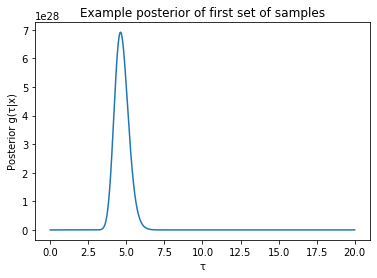

In [12]:
sample = samples[0]
tau_vals = [x for x in np.arange(0.01, 20, 0.01)]
post_vals = [post_list[0](tau) for tau in tau_vals]
plt.plot(tau_vals, post_vals)
plt.xlabel("τ")
plt.ylabel("Posterior g(τ|x)")
plt.title("Example posterior of first set of samples")


Text(0.5, 1.0, 'Example posterior of first set of samples')

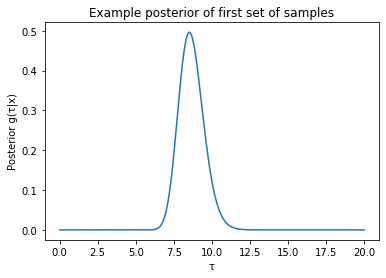

In [13]:
plt.close()
sample = samples[-1]
tau_vals = [x for x in np.arange(0.01, 20, 0.01)]
post_vals = [post_list[-1](tau) for tau in tau_vals]
plt.plot(tau_vals, post_vals)
plt.xlabel("τ")
plt.ylabel("Posterior g(τ|x)")
plt.title("Example posterior of last set of samples")
